In [1]:
from qutip import *
import numpy as np
import scipy as scipy
import os
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

In [2]:
N = 60 # Dimension of the Hilbert space of the cavity
n_q = 200 # Photon saturation number
g_0 = 1 # light-matter coupling
C = 1 # Cooperativity (equal to the pumping parameter p)
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
eta = 0 # Photon loss due to other decay channels
r = 0.45 # Squeezing parameter
theta = np.pi # Squeezing angle
alpha = (np.e**(4*r)-1)/(np.e**(4*r)+1) # omega_p/delta_c
delta_c = 0 # Detuning w_c-w_p
omega_p = alpha*delta_c # Amplitude of the coherent drive (down-conversion)
delta_s = 0 #delta_c*np.sqrt(1-(omega_p/delta_c)**2) # Detuning in the squeezed basis
delta_sigma = -0.01 # Detuning w_sigma-w_p (the same as delta_c to apply RWA)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)
phi = (theta+np.pi)/2
omega = 0

In [3]:
from src_2_0 import wigner_rep

In [4]:
psi = squeeze(N,r*np.exp(1j*np.pi))*basis(N)

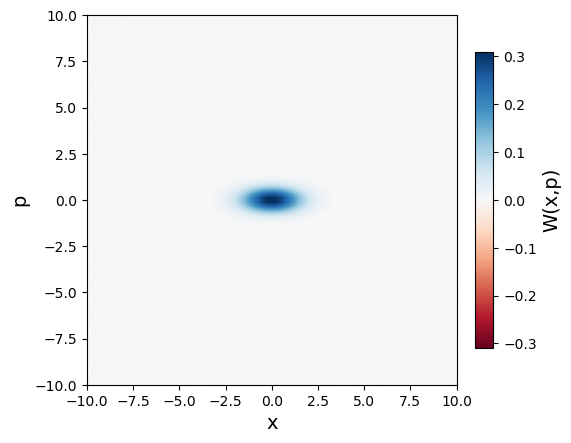

In [5]:
wigner_rep(psi*psi.dag()).wigner_plot(10,10)

In [6]:
a_s = tensor(destroy(N),identity(2)) # Annihilation operator in squeezed basis
a = a_s*np.cosh(r)-np.exp(-1j*theta)*a_s.dag()*np.sinh(r)# Annihilation operator in squeezed basis
sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator

H = delta_s*a_s.dag()*a_s+delta_sigma*sigma.dag()*sigma+g_0*np.cosh(r)*(a_s.dag()*sigma+a_s*sigma.dag())+omega*(a_s*np.exp(1j*phi)+a_s.dag()*np.exp(-1j*phi)) # Hamiltonian of the system in the squeezed basis
Lops = [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a_s]

tau_vec = np.linspace(0,100/k,1000) # Time vector of delays
t_vec = np.linspace(0,10/k,10) # Time vector of times

quad_ang = (theta)/2

#rho_0 = tensor(displace(N,1)*basis(N)*(displace(N,1)*basis(N)).dag(),basis(2,0)*basis(2,0).dag())
psi_0 = tensor(squeeze(N,r*np.exp(1j*theta))*displace(N,np.sqrt(1)*np.exp(1j*((theta+np.pi)/2)))*basis(N),basis(2,0))
rho_0 = psi_0*psi_0.dag()

In [7]:
corr_aa = correlation_2op_2t(H, rho_0, t_vec, tau_vec, Lops, a, a, options=Options(nsteps=10000))
print(1)
corr_adad = correlation_2op_2t(H, rho_0, t_vec, tau_vec, Lops, a.dag(), a.dag(), options=Options(nsteps=10000))
print(2)
corr_ada = correlation_2op_2t(H, rho_0, t_vec, tau_vec, Lops, a.dag(), a, options=Options(nsteps=10000))
print(3)
corr_aad = correlation_2op_2t(H, rho_0, t_vec, tau_vec, Lops, a.dag(), a, options=Options(nsteps=10000))

1
2
3


In [8]:
mean_ad = np.zeros([np.size(t_vec),np.size(tau_vec)])
mean_a = np.zeros([np.size(t_vec),np.size(tau_vec)])

for i in tqdm(range(np.size(t_vec))):
    no_fluc = mesolve(H, rho_0, t_vec[i]*np.ones(np.size(tau_vec))+tau_vec, Lops, [a,a.dag()], options=Options(nsteps=10000))
    mean_a[i,:] = no_fluc.expect[0]
    mean_ad[i,:] = no_fluc.expect[1]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\rodri\AppData\Local\Temp\ipykernel_22324\3172701933.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_a[i,:] = no_fluc.expect[0]
C:\Users\rodri\AppData\Local\Temp\ipykernel_22324\3172701933.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_ad[i,:] = no_fluc.expect[1]
100%|██████████| 10/10 [17:04<00:00, 102.46s/it]


In [9]:
corr = np.zeros([np.size(t_vec),np.size(tau_vec)])

for i in tqdm(range(np.size(t_vec))):
    corr[i,:] = np.exp(-1j*2*quad_ang)*(corr_aa[i,:]-mean_a[0,:]*mean_a[i,:])+(corr_aad[i,:]-mean_ad[0,:]*mean_a[i,:])+(corr_ada[i,:]-mean_a[0,:]*mean_ad[i,:])+np.exp(1j*2*quad_ang)*(corr_adad[i,:]-mean_ad[0,:]*mean_ad[i,:])

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\rodri\AppData\Local\Temp\ipykernel_22324\2395658068.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  corr[i,:] = np.exp(-1j*2*quad_ang)*(corr_aa[i,:]-mean_a[0,:]*mean_a[i,:])+(corr_aad[i,:]-mean_ad[0,:]*mean_a[i,:])+(corr_ada[i,:]-mean_a[0,:]*mean_ad[i,:])+np.exp(1j*2*quad_ang)*(corr_adad[i,:]-mean_ad[0,:]*mean_ad[i,:])
100%|██████████| 10/10 [00:00<00:00, 1998.14it/s]


In [10]:
freqs = np.sort(np.fft.fftfreq(np.size(tau_vec), d=1))
#freqs = np.linspace(-10,10,1000)

In [11]:
spec = np.zeros([np.size(t_vec),np.size(freqs)])
for i in tqdm(range(np.size(t_vec))):
    for j in range(np.size(freqs)):
        spec[i,j] = 2*k*scipy.integrate.simpson(np.cos(freqs[j]*tau_vec)*corr[i,:],x=tau_vec)

100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


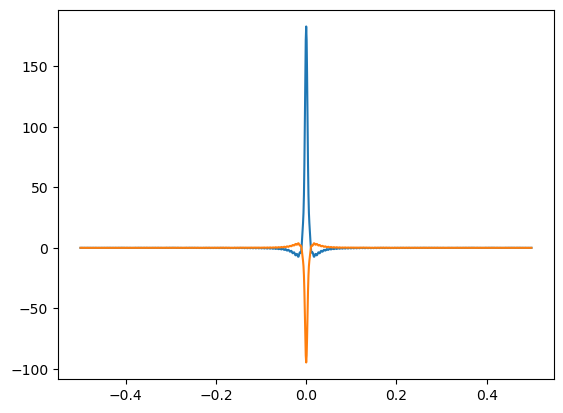

In [19]:
plt.plot(freqs,spec[2])
plt.plot(freqs,spec[0])

In [13]:
'''
spec = np.zeros([np.size(t_vec),np.size(tau_vec)])
for i in tqdm(range(np.size(t_vec))):
    mean_atau = mesolve(H, rho_0, t_vec[i]*np.ones(np.size(tau_vec))+tau_vec, Lops, [a], options=Options(nsteps=10000)).expect[0]
    mean_adtau = mesolve(H, rho_0, t_vec[i]*np.ones(np.size(tau_vec))+tau_vec, Lops, [a.dag()], options=Options(nsteps=10000)).expect[0]
    spec[i,:] = 2*k*(scipy.fft.dct(corr[i]-(mean_t[i]*np.ones(np.size(tau_vec)))*mean_ttau,type=2,norm='ortho'))-np.ones(np.size(tau_vec))

extended_dct = np.zeros([np.size(t_vec),2*np.size(tau_vec)])
for i in range(np.size(t_vec)):
    neg_spec = np.flip(spec[i])
    extended_dct[i] = np.concatenate([neg_spec, spec[i]])

freqs = np.fft.fftfreq(2*np.size(tau_vec), d=1)
'''   

"\nspec = np.zeros([np.size(t_vec),np.size(tau_vec)])\nfor i in tqdm(range(np.size(t_vec))):\n    mean_atau = mesolve(H, rho_0, t_vec[i]*np.ones(np.size(tau_vec))+tau_vec, Lops, [a], options=Options(nsteps=10000)).expect[0]\n    mean_adtau = mesolve(H, rho_0, t_vec[i]*np.ones(np.size(tau_vec))+tau_vec, Lops, [a.dag()], options=Options(nsteps=10000)).expect[0]\n    spec[i,:] = 2*k*(scipy.fft.dct(corr[i]-(mean_t[i]*np.ones(np.size(tau_vec)))*mean_ttau,type=2,norm='ortho'))-np.ones(np.size(tau_vec))\n\nextended_dct = np.zeros([np.size(t_vec),2*np.size(tau_vec)])\nfor i in range(np.size(t_vec)):\n    neg_spec = np.flip(spec[i])\n    extended_dct[i] = np.concatenate([neg_spec, spec[i]])\n\nfreqs = np.fft.fftfreq(2*np.size(tau_vec), d=1)\n"

In [14]:
np.min(spec)

-94.71043014221743

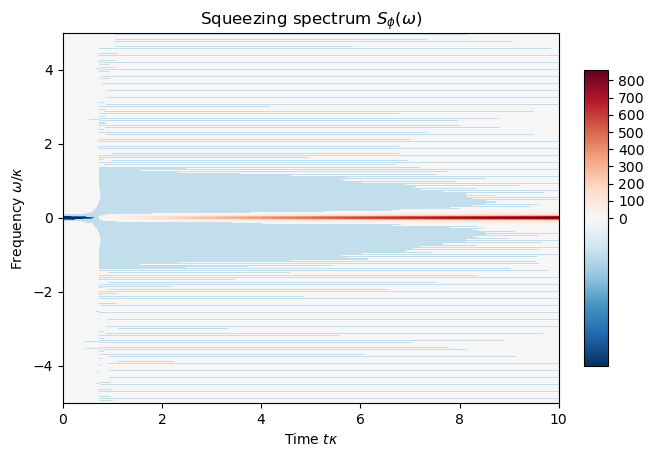

In [18]:
nrm = colors.TwoSlopeNorm(vmin=-20, vcenter=0, vmax=np.max(spec)) # Colorbar settings

fig, ax = plt.subplots()

cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.RdBu_r), cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
ax.contourf(t_vec*k, np.sort(freqs)/k, np.transpose(spec), 100, cmap=cm.RdBu_r, norm=nrm)
ax.set_xlabel(r'Time $t\kappa$')
ax.set_ylabel(r'Frequency $\omega/\kappa$')
plt.title(r'Squeezing spectrum $S_{\phi}(\omega)$')
plt.show()

In [16]:
for i in range(np.size(t_vec)):
    esp = np.column_stack([freqs/k, spec[i]])
    np.savetxt('.\Squeezed_spec/'+str(format(N,'.0f'))+'_'+str(format(t_vec[i]*k,'.0f'))+'.txt',esp)